In [1]:
#import libraries needed
import pandas as pd
import numpy as np 
from matplotlib.colors import to_rgba
import matplotlib.dates as mdates
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [17]:
#read in data needed
#from https://www.misoenergy.org/markets-and-operations/real-time--market-data/market-reports/#nt=%2FMarketReportType%3AHistorical%20LMP%2FMarketReportName%3ADay-Ahead%20EPNode%20LMP%20(zip)&t=10&p=0&s=MarketReportPublished&sd=desc
DA_LMP_train = pd.read_csv('data/cleaned/DA/miso_da_combined_clean.csv', index_col = 0)
DA_LMP_train['datetime'] = pd.to_datetime(DA_LMP_train['datetime'])

In [18]:
# Adding tradable FTR source/sink path information to see if there is actually a viable trading path
tradable_FTR = pd.read_csv('Outputs/LMP_FTR_Mapping.csv', index_col = 0)
tradable_FTR.columns = ['node', 'matched_source_sink', 'match_score']

In [19]:
def split_dataframe_by_hour_range_and_weekday(df, start_hour=7, end_hour=22, datetime_col=None):
    # Create a copy to avoid modifying the original DataFrame
    temp_df = df.copy()
    
    # If datetime column is specified, use it; otherwise use the index
    if datetime_col is not None:
        # Ensure the datetime column is in datetime format
        temp_df[datetime_col] = pd.to_datetime(temp_df[datetime_col])
        
        # Extract hour and day of week from the datetime column
        hours = temp_df[datetime_col].dt.hour
        day_of_week = temp_df[datetime_col].dt.dayofweek  # Monday=0, Sunday=6
        
        # Filter based on hour and day of week
        # For day_df: Only include weekdays (0-4) and hours within range
        day_df = temp_df[(day_of_week < 5) & (hours >= start_hour) & (hours < end_hour)]
        
        # For night_df: Include weekends (5-6) or hours outside range
        night_df = temp_df[(day_of_week >= 5) | (hours < start_hour) | (hours >= end_hour)]
    else:
        # Ensure the index is in datetime format
        if not isinstance(temp_df.index, pd.DatetimeIndex):
            temp_df.index = pd.to_datetime(temp_df.index)
        
        # Extract hour and day of week from the index
        hours = temp_df.index.hour
        day_of_week = temp_df.index.dayofweek  # Monday=0, Sunday=6
        
        # Filter based on hour and day of week
        # For day_df: Only include weekdays (0-4) and hours within range
        day_df = temp_df[(day_of_week < 5) & (hours >= start_hour) & (hours < end_hour)]
        
        # For night_df: Include weekends (5-6) or hours outside range
        night_df = temp_df[(day_of_week >= 5) | (hours < start_hour) | (hours >= end_hour)]
    
    return day_df, night_df

In [20]:
# Calculate skewness by category
def calc_skewness(group):
    return stats.skew(group)

# Calculate kurtosis by category
def calc_kurtosis(group):
    return stats.kurtosis(group)

In [21]:
def mean_std_across_clusters(X, k):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels = kmeans.fit_predict(X)
    # compute intra-cluster standard deviation across all features
    cluster_stds = []
    for cluster_id in np.unique(labels):
        cluster_data = X[labels == cluster_id]
        if cluster_data.shape[0] > 1:
            cluster_std = cluster_data.std(axis=0).mean()  # average std across features
            cluster_stds.append(cluster_std)
    return np.mean(cluster_stds)

In [22]:
#split data to on and off peak for calculations
on_peak_DA_LMP_train, off_peak_DA_LMP_train = split_dataframe_by_hour_range_and_weekday(DA_LMP_train, datetime_col='datetime')

# Basic std calculation
std_by_node_on_peak = on_peak_DA_LMP_train.groupby('node')['congestion'].std()
std_by_node_off_peak = off_peak_DA_LMP_train.groupby('node')['congestion'].std()

# Basic mean calculation
mean_by_node_on_peak = on_peak_DA_LMP_train.groupby('node')['congestion'].mean()
mean_by_node_off_peak = off_peak_DA_LMP_train.groupby('node')['congestion'].mean()

# congestion skew
skew_by_node_on_peak = on_peak_DA_LMP_train.groupby('node')['congestion'].apply(calc_skewness)
skew_by_node_off_peak = off_peak_DA_LMP_train.groupby('node')['congestion'].apply(calc_skewness)

# congestion kurtosis
kurtosis_by_node_on_peak = on_peak_DA_LMP_train.groupby('node')['congestion'].apply(calc_kurtosis)
kurtosis_by_node_off_peak = off_peak_DA_LMP_train.groupby('node')['congestion'].apply(calc_kurtosis)

#combining metrics together in one dataframe
onPeakCombined = pd.concat([std_by_node_on_peak, mean_by_node_on_peak, skew_by_node_on_peak, kurtosis_by_node_on_peak], axis = 1, ignore_index=False)
offPeakCombined = pd.concat([std_by_node_off_peak, mean_by_node_off_peak, skew_by_node_off_peak, kurtosis_by_node_off_peak], axis = 1, ignore_index=False)

#Renaming columns for clarity
onPeakCombined.columns = ['congestion deviation','congestion mean','congestion skew', 'congestion kurtosis']
offPeakCombined.columns = ['congestion deviation','congestion mean','congestion skew', 'congestion kurtosis']


In [23]:
# Merging scoring information with LMP information
onPeakCombined = pd.merge(tradable_FTR, onPeakCombined, on='node')
offPeakCombined = pd.merge(tradable_FTR, offPeakCombined, on='node')

In [24]:
##### Defining a score based on weightings that will find a desirable sink node ######
features = ['congestion deviation',	'congestion mean', 'congestion skew', 'congestion kurtosis']
scaler = MinMaxScaler()
onPeakCombined_scaled = pd.DataFrame(scaler.fit_transform(onPeakCombined[features]), columns=[f + '_scaled' for f in features])
offPeakCombined_scaled = pd.DataFrame(scaler.fit_transform(offPeakCombined[features]), columns=[f + '_scaled' for f in features])

onPeakCombined_scaled.index = onPeakCombined.index
offPeakCombined_scaled.index = offPeakCombined.index

# Define weights (customize based on your strategy)
weights = {
    'congestion mean_scaled': 0.45,            # prioritize high average congestion
    'congestion deviation_scaled': 0.1,       # moderate risk
    'congestion skew_scaled': 0.15,            # some directional preference
    'congestion kurtosis_scaled': -0.15,       # care about spikiness
}

# Add score column
onPeakCombined_scaled['Sink score'] = sum(onPeakCombined_scaled[col] * weight for col, weight in weights.items())
offPeakCombined_scaled['Sink score'] = sum(offPeakCombined_scaled[col] * weight for col, weight in weights.items())

# Add back node names
onPeakCombined['Sink score'] = onPeakCombined_scaled['Sink score']
offPeakCombined['Sink score'] = offPeakCombined_scaled['Sink score']

In [25]:
##### Defining a score based on weightings that will find a desirable source node #####
features = ['congestion deviation',	'congestion mean', 'congestion skew', 'congestion kurtosis']
scaler = MinMaxScaler()
onPeakCombined_scaled = pd.DataFrame(scaler.fit_transform(onPeakCombined[features]), columns=[f + '_scaled' for f in features])
offPeakCombined_scaled = pd.DataFrame(scaler.fit_transform(offPeakCombined[features]), columns=[f + '_scaled' for f in features])

onPeakCombined_scaled.index = onPeakCombined.index
offPeakCombined_scaled.index = offPeakCombined.index

# Define weights (customize based on your strategy)
weights = {
    'congestion mean_scaled': 0.4,             # prioritize negative average congestion
    'congestion deviation_scaled': 0.05,       # little risk
    'congestion skew_scaled': 0.05,            # some directional preference
    'congestion kurtosis_scaled': 0.3,         # penalize spikiness
}

# Add score column
onPeakCombined_scaled['Source score'] = -1 * sum(onPeakCombined_scaled[col] * weight for col, weight in weights.items())
offPeakCombined_scaled['Source score'] = -1 * sum(offPeakCombined_scaled[col] * weight for col, weight in weights.items())

# Add back node names
onPeakCombined['Source score'] = onPeakCombined_scaled['Source score']
offPeakCombined['Source score'] = offPeakCombined_scaled['Source score']

In [26]:
# Initialize scaler for 0-100
scaler = MinMaxScaler(feature_range=(0, 100))

# Scale Sink score
onPeakCombined['Source score'] = scaler.fit_transform(onPeakCombined[['Source score']])
offPeakCombined['Source score'] = scaler.fit_transform(offPeakCombined[['Source score']])

# Scale Source score (note: lower source score is better, so we invert it)
onPeakCombined['Sink score'] = scaler.fit_transform(onPeakCombined[['Sink score']])
offPeakCombined['Sink score'] = scaler.fit_transform(offPeakCombined[['Sink score']])

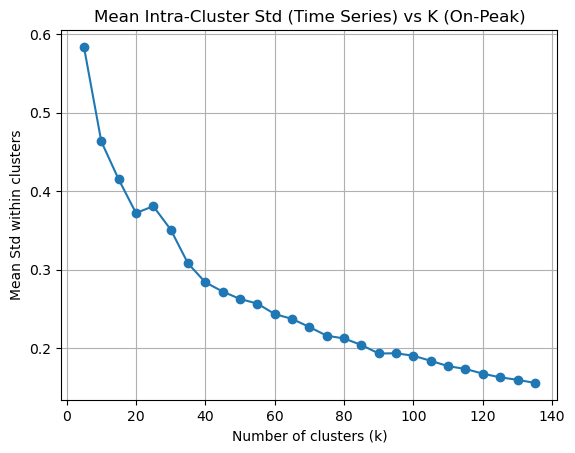

In [27]:
######## ON PEAK CLUSTERING FOR CONGESTION TIME SERIES ###########
# Pivot congestion to wide format: rows = nodes, columns = timestamps
pivot_df = on_peak_DA_LMP_train.pivot(index='node', columns='datetime', values='congestion').fillna(0)

# Standardize time series for each node
X_time_series = StandardScaler().fit_transform(pivot_df)

# Run cluster evaluation loop
k_values = []
std_values = []

for k in range(5, 140, 5):
    mean_std = mean_std_across_clusters(X_time_series, k)
    k_values.append(k)
    std_values.append(mean_std)

# Plot mean intra-cluster std vs k
plt.plot(k_values, std_values, marker='o')
plt.title('Mean Intra-Cluster Std (Time Series) vs K (On-Peak)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Mean Std within clusters')
plt.grid(True)
plt.show()

In [28]:
# Cluster the time series data
n_clusters = 80
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
labels = kmeans.fit_predict(X_time_series)

# Map the labels back to node names (index of pivot_df)
cluster_df = pd.DataFrame({
    'node': pivot_df.index,
    'cluster': labels
})

# Merge clusters into onPeakCombined by 'node'
onPeakCombined = onPeakCombined.merge(cluster_df, on='node', how='inner')

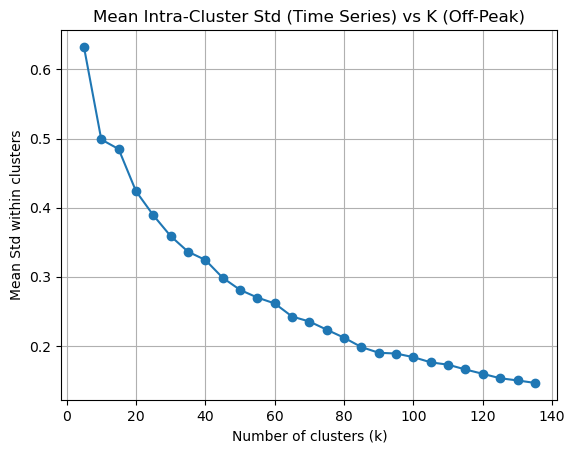

In [29]:
######## OFF PEAK CLUSTERING FOR CONGESTION TIME SERIES ###########
# Pivot congestion to wide format: rows = nodes, columns = timestamps
pivot_df = off_peak_DA_LMP_train.pivot(index='node', columns='datetime', values='congestion').fillna(0)

# Standardize time series for each node
X_time_series = StandardScaler().fit_transform(pivot_df)

# Run cluster evaluation loop
k_values = []
std_values = []

for k in range(5, 140, 5):
    mean_std = mean_std_across_clusters(X_time_series, k)
    k_values.append(k)
    std_values.append(mean_std)

# Plot mean intra-cluster std vs k
plt.plot(k_values, std_values, marker='o')
plt.title('Mean Intra-Cluster Std (Time Series) vs K (Off-Peak)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Mean Std within clusters')
plt.grid(True)
plt.show()

In [30]:
# Cluster the time series data
n_clusters = 80
kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42)
labels = kmeans.fit_predict(X_time_series)

# Map the labels back to node names (index of pivot_df)
cluster_df = pd.DataFrame({
    'node': pivot_df.index,
    'cluster': labels
})

# Merge clusters into onPeakCombined by 'node'
offPeakCombined = offPeakCombined.merge(cluster_df, on='node', how='inner')

In [31]:
# Sorting so the best sink scores show up on top when saved to csv
onPeakCombined = onPeakCombined.sort_values('Sink score', ascending=False)
offPeakCombined = offPeakCombined.sort_values('Sink score', ascending=False)

#saving the best sink nodes for off peak and on peak strategies
onPeakCombined.to_csv('Outputs/onPeakScoring.csv')
offPeakCombined.to_csv('Outputs/offPeakScoring.csv')